# Attempt on integrating scRNA data with SCVI tools
## Initial imports and definition of helper functions

In [ ]:
import scanpy as sc
import glob
import os
from functools import reduce
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


def compute_qc_metrics(adata):
    # flatten is needed due to csr_matrix.sum returning a numpy.matrix object
    # which cannot be broadcasted to obs frame
    adata.obs['nFeature_RNA'] = np.array((adata.X > 0).sum(axis = 1)).flatten()
    adata.obs['nCount_RNA'] = np.array(adata.X.sum(axis = 1)).flatten()
    adata.obs['percent_mt'] = np.array(
        adata[:, adata.var.index.str.match('^MT.')].X.sum(axis = 1) / adata.X.sum(axis = 1) * 100
    ).flatten()

    adata.obs['percent_ribo'] = np.array(
        adata[:, adata.var.index.str.match('^RP[SL]')].X.sum(axis = 1) / adata.X.sum(axis = 1) * 100
    ).flatten()


def apply_qc_thresholds(adata, sample_id_column, sample_thresholds):
    adata.obs['qc_pass'] = True
    for sample_id, thresholds in sample_thresholds.items():
        df = adata.obs.loc[adata.obs[sample_id_column] == sample_id, :]
        feature_qcs = []
        for feature, (lo, hi) in thresholds.items():
            feature_qcs.append(
                df[feature].apply(lambda x: x > lo and x < hi).values
            )
        
        qc_pass = np.all(
            np.vstack(feature_qcs),
            axis = 0
        )
        adata.obs.loc[adata.obs[sample_id_column] == sample_id, 'qc_pass'] = qc_pass


def generate_plots(
    axs, 
    df,
    qc_pass_idx, 
    thresholds = None
):
    datacols = ['nFeature_RNA', 'percent_mt', 'percent_ribo']
    hue = ['pass' if x else 'fail' for x in qc_pass_idx] if not all(qc_pass_idx) else None
    palette = {'pass': '#4B72B1', 'fail': 'red'} if hue else None
    for j, datacol in enumerate(datacols):
        sns.histplot(
            x = df.loc[:, datacol],
            ax = axs[0, j],
            hue = hue,
            palette = palette,
            kde = True,
            fill = True
        )
        if thresholds and datacol in thresholds:
            for position in thresholds[datacol]:
                if position:
                    axs[0, j].axvline(
                        position,
                        color = 'k',
                        linewidth = 1
                    )
                
    
    xy = [
        ('nCount_RNA', 'nFeature_RNA'),
        ('nFeature_RNA', 'percent_mt'),
        ('percent_mt', 'percent_ribo')
    ]
    for j, (xcol, ycol) in enumerate(xy): 
        sns.scatterplot(
            x = df.loc[:, xcol],
            y = df.loc[:, ycol],
            ax = axs[1, j],
            hue = hue,
            palette = palette,
            edgecolor = 'k',
            facecolor = None,
            color = None,
            alpha = 0.5
        )
        sns.kdeplot(
            x = df.loc[qc_pass_idx, xcol],
            y = df.loc[qc_pass_idx, ycol],
            ax = axs[1, j],
            color = 'lightblue'
        )
        
        if thresholds:
            for key, plotline in zip(
                [xcol, ycol],
                [axs[1, j].axvline, axs[1, j].axhline]
            ):
                if key in thresholds:
                    for position in thresholds[key]:
                        if position:
                            plotline(
                                position,
                                color = 'k',
                                linewidth = 1
                            )

                            
def plot_qc(
    adata,
    thresholds = None, 
    sample_id_column = None,
    sharex = False
):
    if not sample_id_column:
        fig, axs = plt.subplots(2, 3)
        generate_plots(
            axs,
            adata.obs,
            qc_pass_idx = adata.obs[column_dict['qc_pass']] if 'qc_pass' in adata.obs.columns else [True] * adata.obs.shape[0],
            thresholds = thresholds
        )
        
    else:
        fig, axs = plt.subplots(
            adata.obs[sample_id_column].nunique(), 
            6, 
            sharex = 'col' if sharex else 'none'
        )
        for i, sample_id in enumerate(adata.obs[sample_id_column].unique()):
            tmp_df = adata[adata.obs[sample_id_column] == sample_id, :].obs
            generate_plots(
                axs[i, :].reshape(2, 3),
                tmp_df,
                qc_pass_idx = tmp_df['qc_pass'] if 'qc_pass' in tmp_df.columns else [True] * tmp_df.shape[0],
                thresholds = thresholds[sample_id] if thresholds else None
            )
            axs[i, 0].set_ylabel(sample_id)
    
    return fig

## Quality control of raw data

In [ ]:
adata = sc.read_h5ad(
    '../data/inflammatory_disease.h5ad'
)
# remove UC, atopic dermatitis, pbmcs and doublets
adata = adata[
    ~adata.obs.sample_id.str.startswith('GSM') &
    (adata.obs.tissue.str.startswith('blood') | adata.obs.tissue.str.startswith('Blood')) &
    ~adata.obs.doublet
].copy()
adata

AnnData object with n_obs × n_vars = 45977 × 33538
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score'

In [ ]:
compute_qc_metrics(adata)

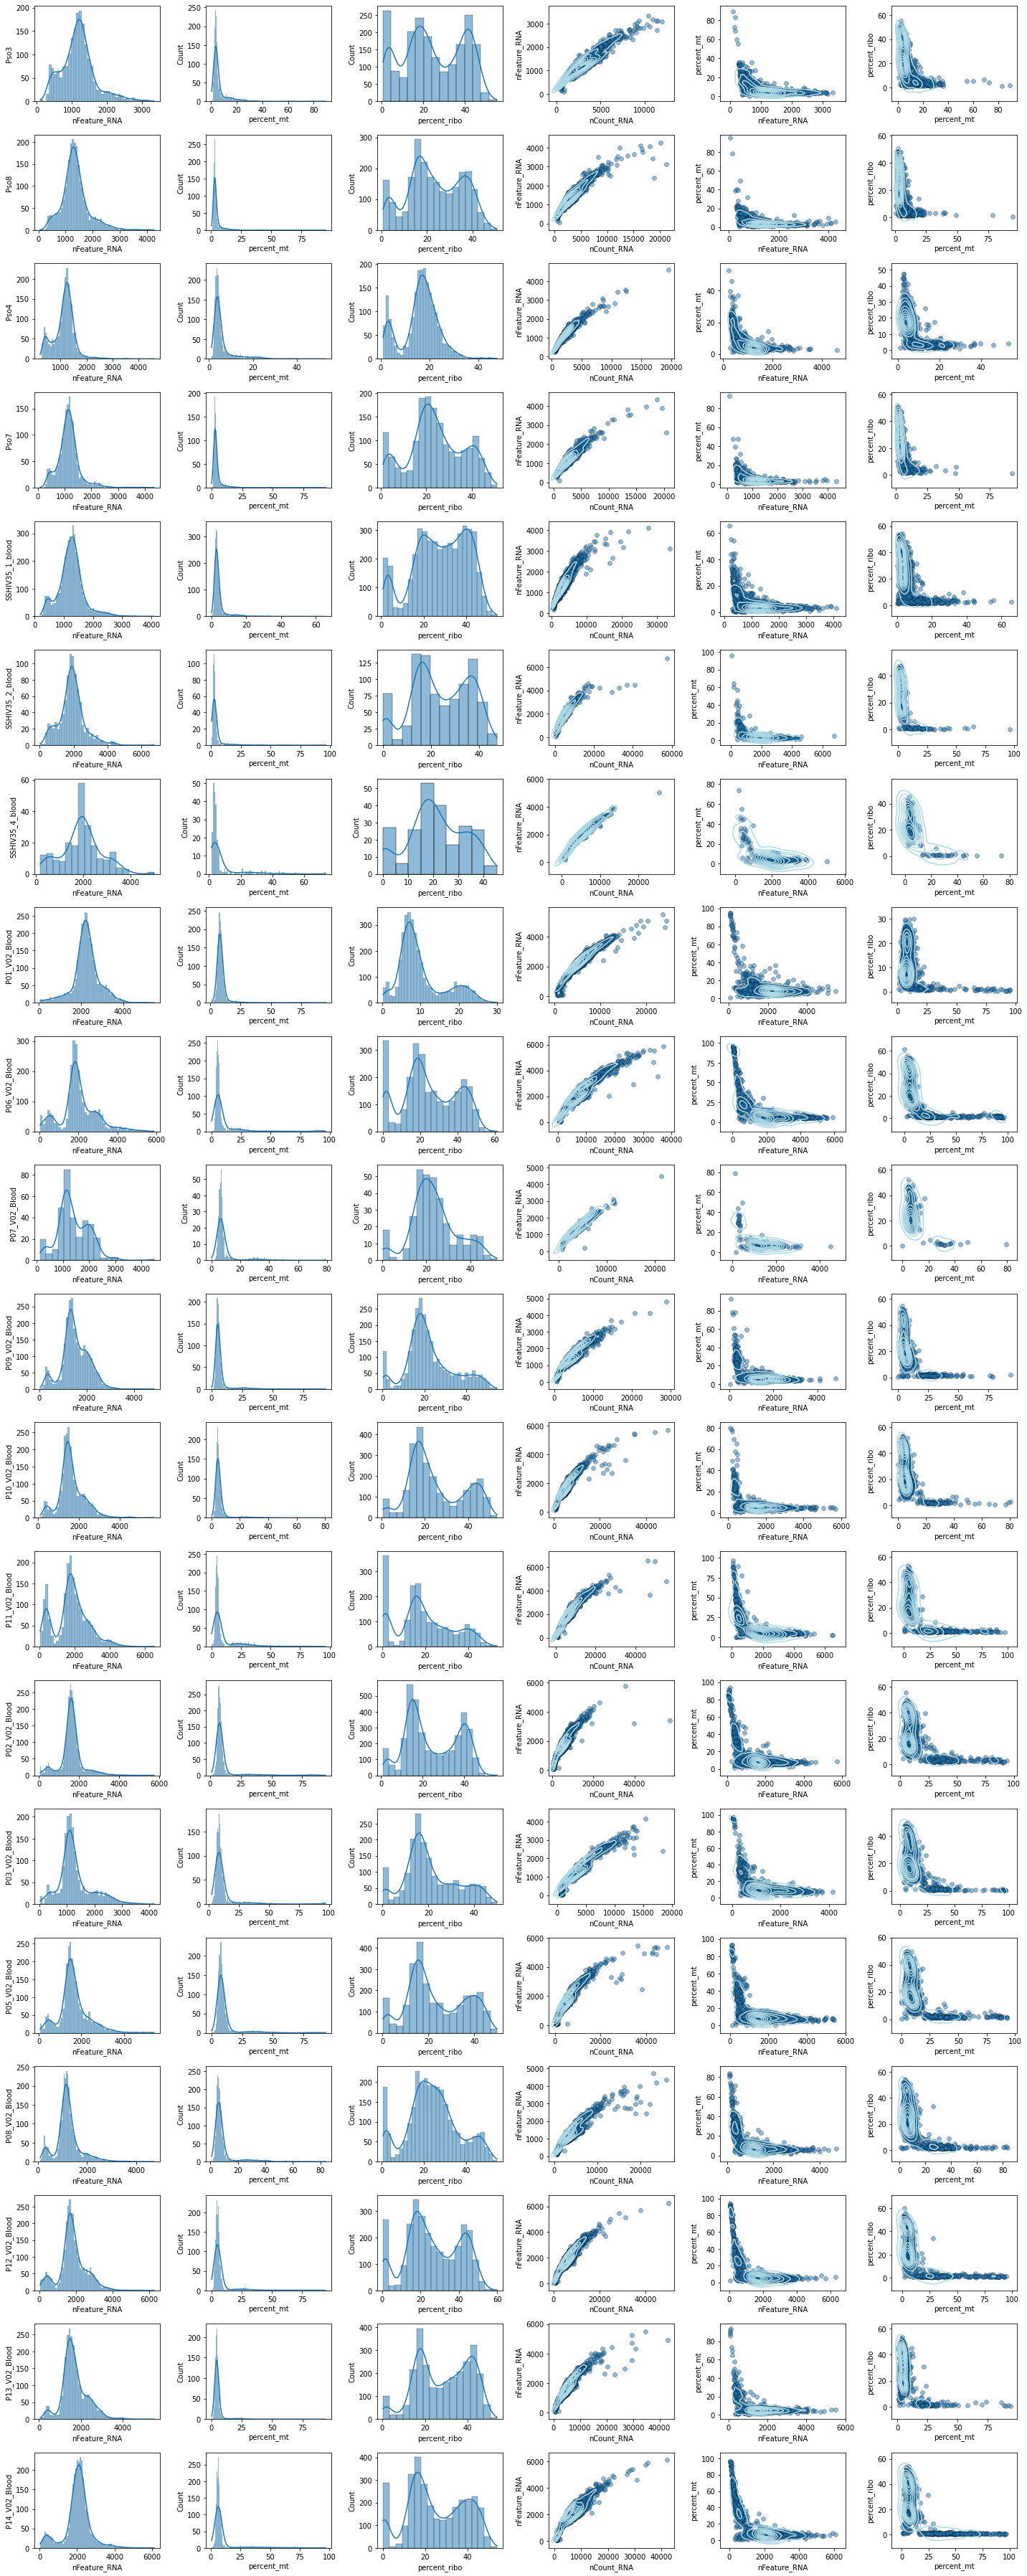

In [ ]:
fig = plot_qc(
    adata,
    sample_id_column = 'sample_id'
)
fig.set_figwidth(20)
fig.set_figheight(adata.obs.sample_id.nunique() * 2.5)
fig.tight_layout()

In [ ]:
MIN_RNA_FEATURES = 750
MAX_RNA_FEATURES = 5000
MAX_PERCENT_MT = 15
qc_thresholds = {
    k: {'nFeature_RNA': (MIN_RNA_FEATURES, MAX_RNA_FEATURES), 'percent_mt': (0, MAX_PERCENT_MT), 'percent_ribo': (5, 100)} 
    for k in adata.obs.sample_id
}

try:
    assert len(qc_thresholds) == adata.obs.sample_id.nunique()
    
except AssertionError:
    print('qc_threshold does not have the same length as there are unique sample_ids! Please make sure all sample_ids are in qc_thresholds!')
    raise AssertionError
    
try:
    assert all(x in qc_thresholds for x in adata.obs.sample_id.unique())
    
except AssertionError:
    print([x for x in adata.obs.sample_id.unique() if not x in qc_thresholds], 'are missing from qc_thresholds! Please check your code!')
    raise AssertionError

apply_qc_thresholds(
    adata, 
    'sample_id', 
    qc_thresholds
)
ncells = adata.obs.shape[0]
nfiltered = ncells - adata.obs.qc_pass.sum()
print(
    f'{nfiltered} of {ncells} cells would be removed using the current qc thresholds'
)

5829 of 45977 cells would be removed using the current qc thresholds


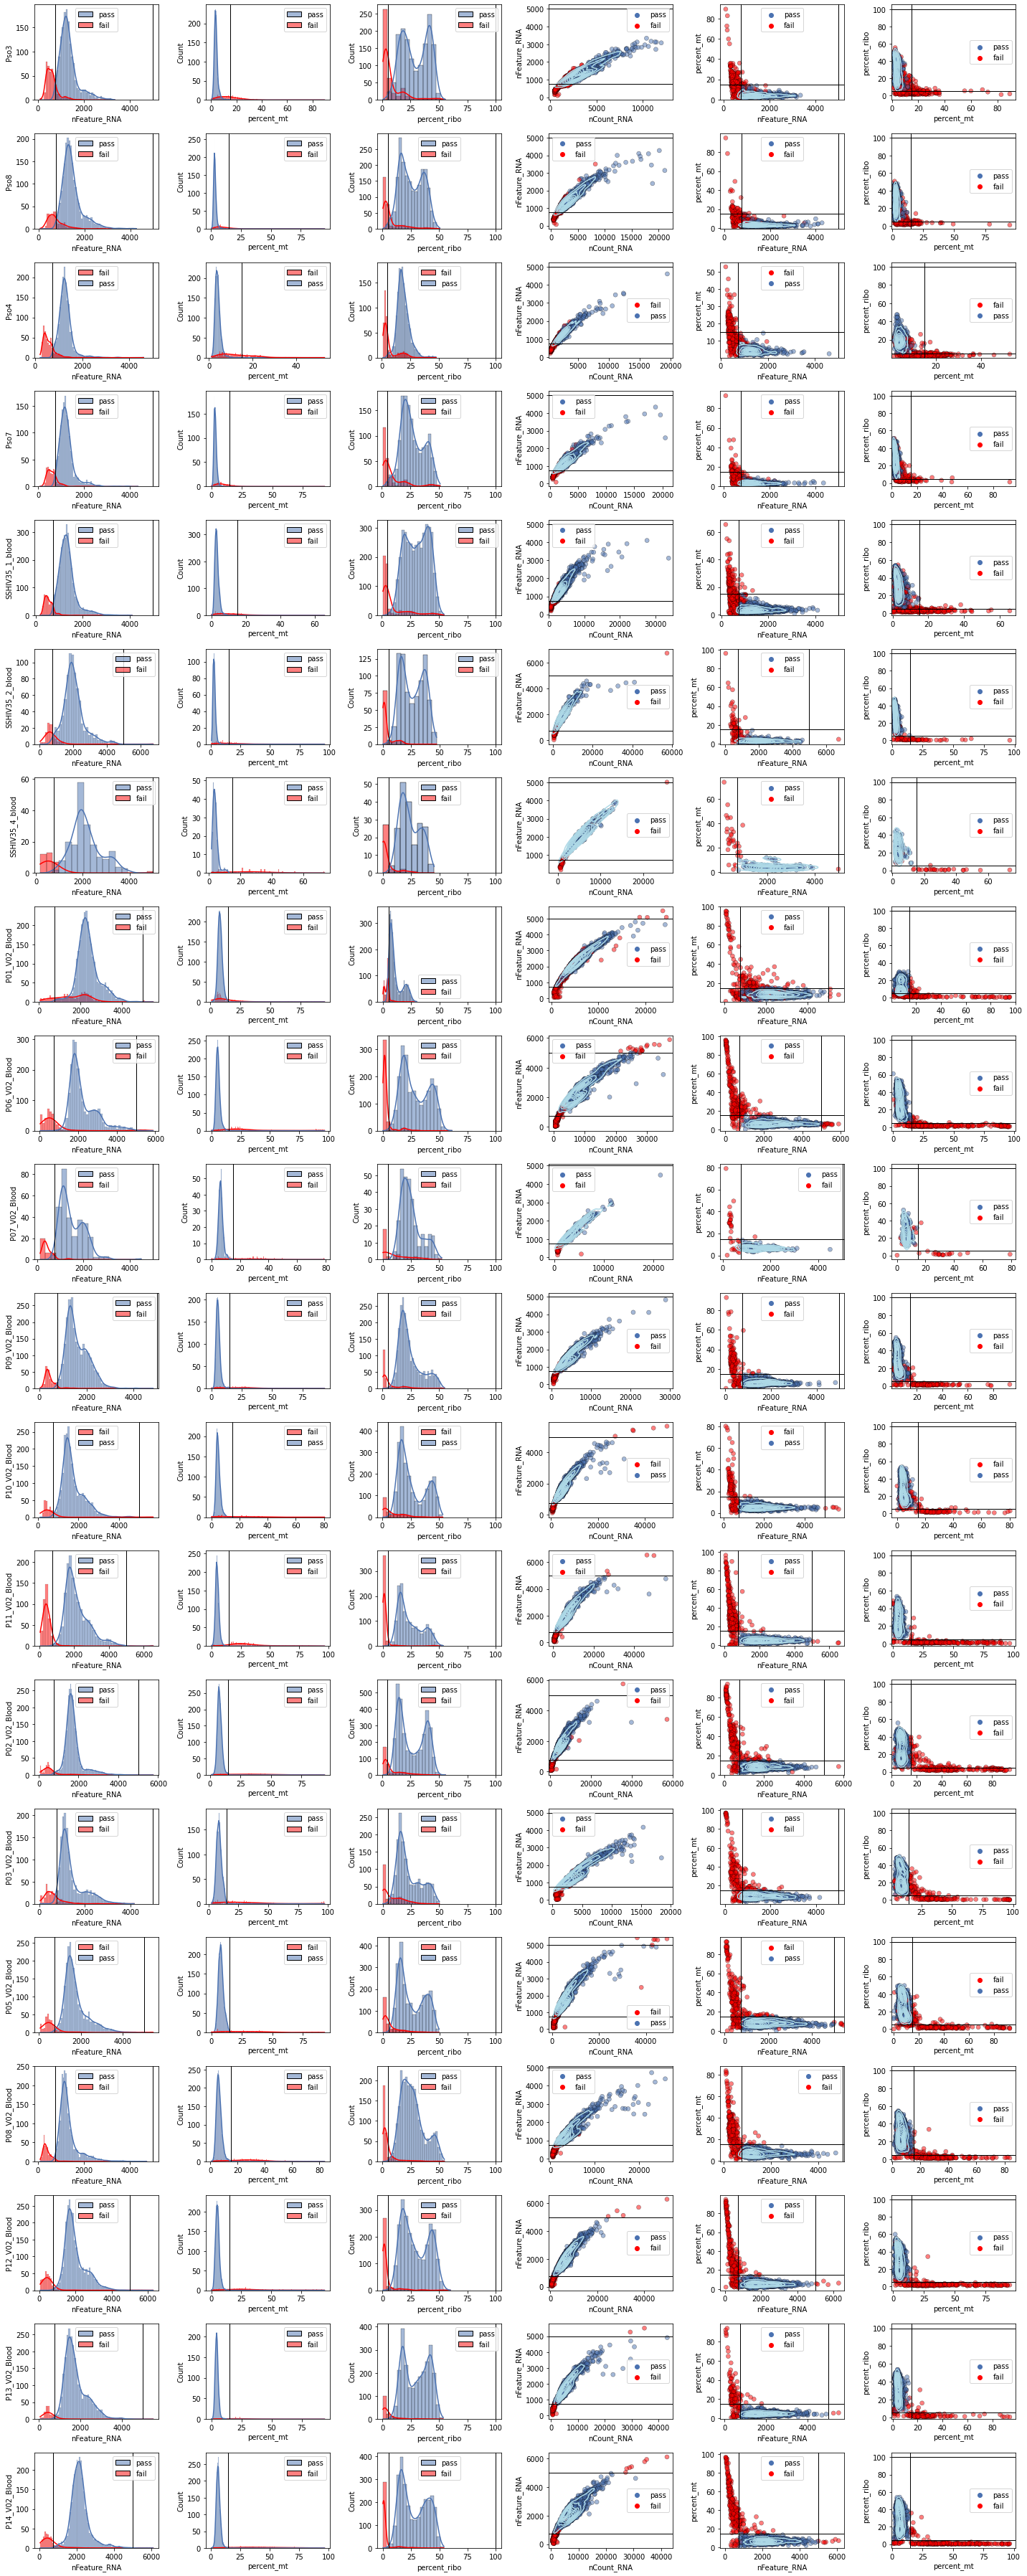

In [ ]:
fig = plot_qc(
    adata,
    thresholds = qc_thresholds,
    sample_id_column = 'sample_id'
)
fig.set_figwidth(20)
fig.set_figheight(adata.obs.sample_id.nunique() * 2.5)
fig.tight_layout()

In [ ]:
# apply qc filter
adata = adata[adata.obs.qc_pass, :].copy()

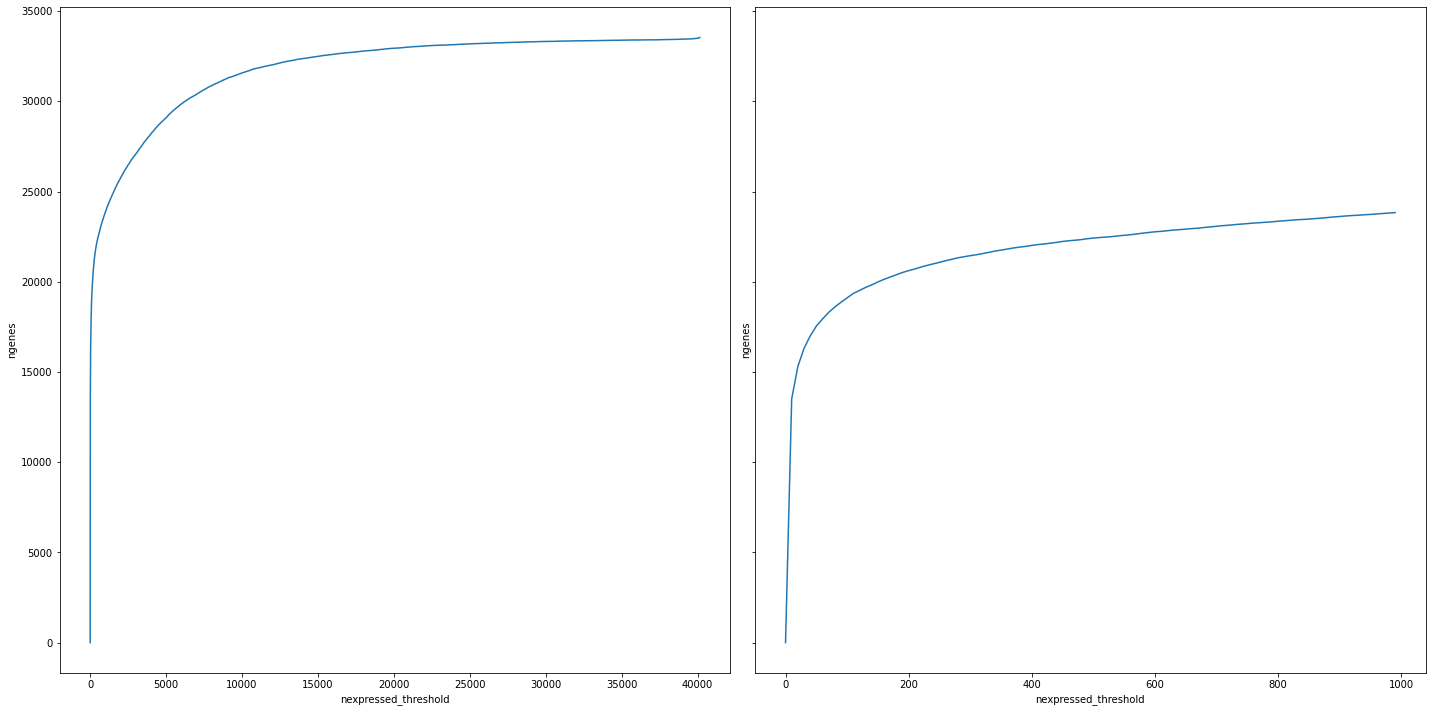

In [ ]:
def get_nexpressed(adata):
    return np.array((adata.X > 0).sum(axis = 0)).flatten()

def plot_removal_curve(adata, axs = None):
    fig = None
    if not isinstance(axs, np.ndarray):
        fig, axs = plt.subplots(1, 2, sharey = True)
    
    expressed = get_nexpressed(adata)
    thresholds_global = np.arange(0, adata.shape[0], 10)
    thresholds_local = np.arange(0, 1000, 10)
    
    # global
    axs[0].plot(
        thresholds_global,
        [(expressed < threshold).sum() for threshold in thresholds_global]
    )
    
    # local
    axs[1].plot(
        thresholds_local,
        [(expressed < threshold).sum() for threshold in thresholds_local]
    )
    for ax in axs:
        ax.set_ylabel('ngenes')
        ax.set_xlabel('nexpressed_threshold')
    
    return fig, ax if fig else ax

fig, axs = plt.subplots(1, 2, sharey = True)
plot_removal_curve(adata, axs = axs)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [ ]:
# filter genes
nexpressed_threshold = 50
ngenes_passed = (get_nexpressed(adata) >= nexpressed_threshold).sum()
ngenes = adata.var.shape[0]
print(
    f'{ngenes_passed} of {ngenes} are retained requiring their expression in {nexpressed_threshold} or more cells'
)

15998 of 33538 are retained requiring their expression in 50 or more cells


In [ ]:
adata = adata[:, (get_nexpressed(adata) >= nexpressed_threshold)].copy()

In [ ]:
adata.write(
    '../data/blood_inflammatory_disease.qcfiltered.h5ad'
)